In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import h3
import folium
import branca.colormap as cm

In [2]:
df_orders = pd.read_csv('D:\Python\StrataScratch\Business Analysis\insights_from_failed_orders\data_orders.csv')
df_offers = pd.read_csv('D:\Python\StrataScratch\Business Analysis\insights_from_failed_orders\data_offers.csv')

#### Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

In [3]:
## Creating new Columns
## Mapping is_driver_assigned_key to driver_assigned = yes or no
## Mapping order_status_key to order_status = cancelled by client or cancelled by system
df_orders['driver_assigned'] = np.where(df_orders.is_driver_assigned_key == 0, 'No','Yes' )
df_orders['order_status'] = np.where(df_orders.order_status_key == 4, 'Cancelled by client','Cancelled by system')

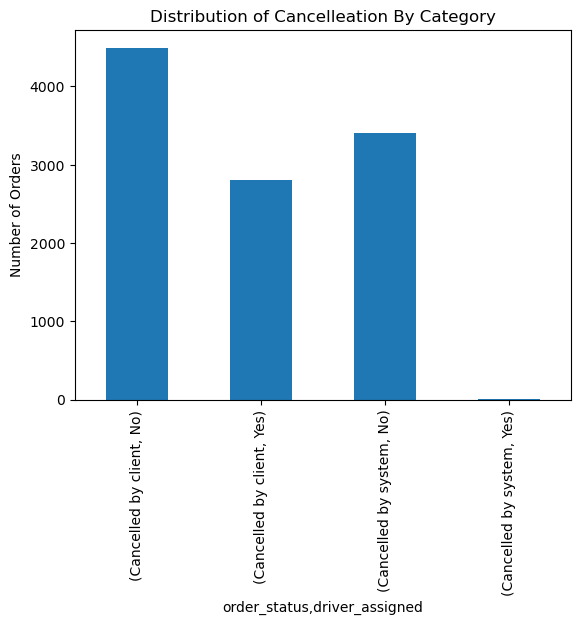

In [4]:
#Plotting bar chart based on order rejection reason and assignment of driver
cancellation_reason = df_orders.groupby(['order_status','driver_assigned'])['order_gk'].count()
#pivot_table = cancellation_reason.pivot_table(index='order_status', columns='driver_assigned', values='orders_gk')
bar_plot = cancellation_reason.plot(kind='bar')
bar_plot.set_title('Distribution of Cancelleation By Category')
bar_plot.set_ylabel('Number of Orders')
plt.show()

#### Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

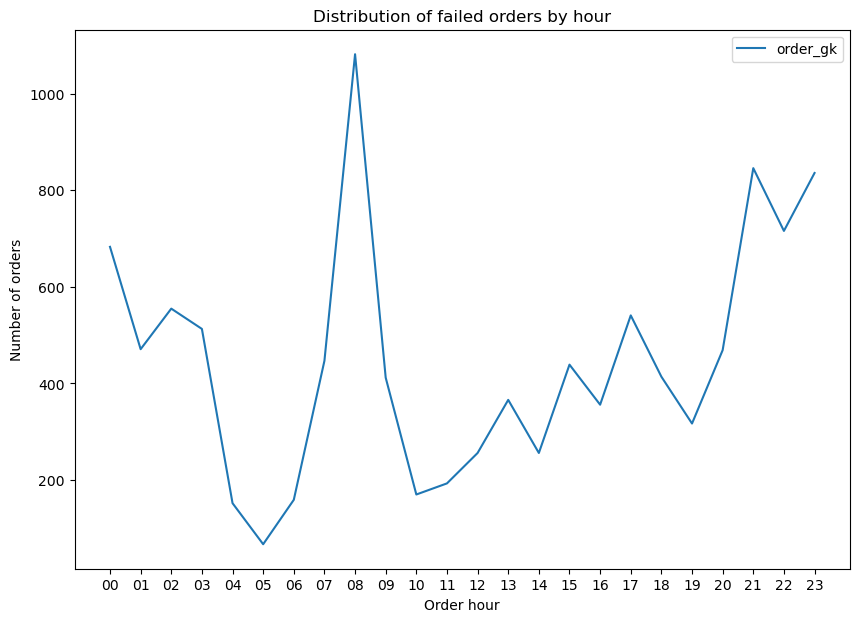

In [5]:
df_orders['order_time'] = df_orders['order_datetime'].str[0:2]
order_time = df_orders.groupby('order_time')['order_gk'].count()
line_chart = order_time.plot(figsize= (10,7),
                             legend=True, 
                             xticks=range(0,24),
                             title='Distribution of failed orders by hour',
                             ylabel='Number of orders',
                             xlabel='Order hour')


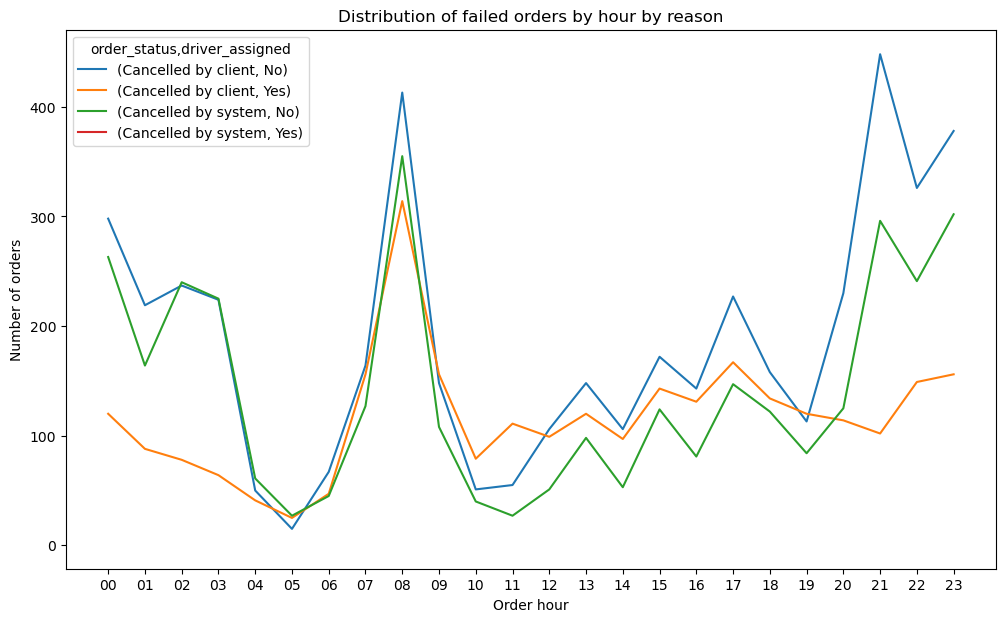

In [6]:
line_chart_reason = df_orders.groupby(['order_time','order_status','driver_assigned'])['order_gk'].count()
"""
The index is a MultiIndex (order_time, order_status, driver_assigned).
The values are counts of order_gk"""
line_chart_reason.reset_index().pivot(index='order_time',
                                      columns=['order_status','driver_assigned'],
                                      values='order_gk').plot(
                                                              figsize= (12,7),
                                                              legend=True, 
                                                              xticks=range(0,24),
                                                              title='Distribution of failed orders by hour by reason',
                                                              ylabel='Number of orders',
                                                              xlabel='Order hour')
"""After reset_index()-
The multi-level index has been turned into normal columns.
A new default index 0,1,2,… is assigned.
Because .pivot() requires the grouping keys (order_time, order_status, driver_assigned) to be columns, not indices.
So reset_index() is preparing the data for the pivot step"""
plt.show()

#### Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

In [7]:
df_orders.groupby(['order_time','driver_assigned'])['cancellations_time_in_seconds'].mean()

order_time  driver_assigned
00          No                 111.557047
            Yes                293.616667
01          No                  98.132420
            Yes                247.715909
02          No                 106.438819
            Yes                303.307692
03          No                 104.361607
            Yes                292.640625
04          No                  90.000000
            Yes                243.219512
05          No                 121.800000
            Yes                314.400000
06          No                 124.955224
            Yes                272.553191
07          No                 112.628049
            Yes                188.891026
08          No                 120.702179
            Yes                189.025478
09          No                 120.000000
            Yes                216.493590
10          No                  74.607843
            Yes                197.860759
11          No                  77.945455
      

In [8]:
#Finding outliers in the dataset. A better approach - Z-score.
df_orders['z_scores_cancellation_time'] = np.abs(stats.zscore(df_orders['cancellations_time_in_seconds'],nan_policy='omit'))

In [9]:
#Finding mean of the cancellation_time_in_seconds. Get mean from data frame without nan and zscore < 3. Fill that mean in the nan column of the original df
filtered_df_orders = df_orders.loc[df_orders['z_scores_cancellation_time'] < 3]
mean_filtered_data = filtered_df_orders['cancellations_time_in_seconds'].mean()

In [10]:
filled_mean_df_orders = df_orders
filled_mean_df_orders['cancellations_time_in_seconds'] = filled_mean_df_orders['cancellations_time_in_seconds'].fillna(value=mean_filtered_data)
filled_mean_df_orders

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,driver_assigned,order_status,order_time,z_scores_cancellation_time
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.000000,Yes,Cancelled by client,18,0.187989
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.000000,No,Cancelled by client,20,0.140106
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.000000,Yes,Cancelled by client,12,0.524447
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.000000,Yes,Cancelled by client,13,0.449454
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,137.472707,No,Cancelled by system,21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
10711,13:11:35,-0.975372,51.457846,NaN,3000599186906,4,0,36.000000,No,Cancelled by client,13,0.571318
10712,13:13:55,-0.975372,51.457846,NaN,3000599186962,4,0,4.000000,No,Cancelled by client,13,0.721305
10713,13:17:21,-0.972926,51.457693,60.0,3000599187034,4,1,34.000000,Yes,Cancelled by client,13,0.580692
10714,13:16:28,-0.975372,51.457846,NaN,3000599187024,4,0,6.000000,No,Cancelled by client,13,0.711930


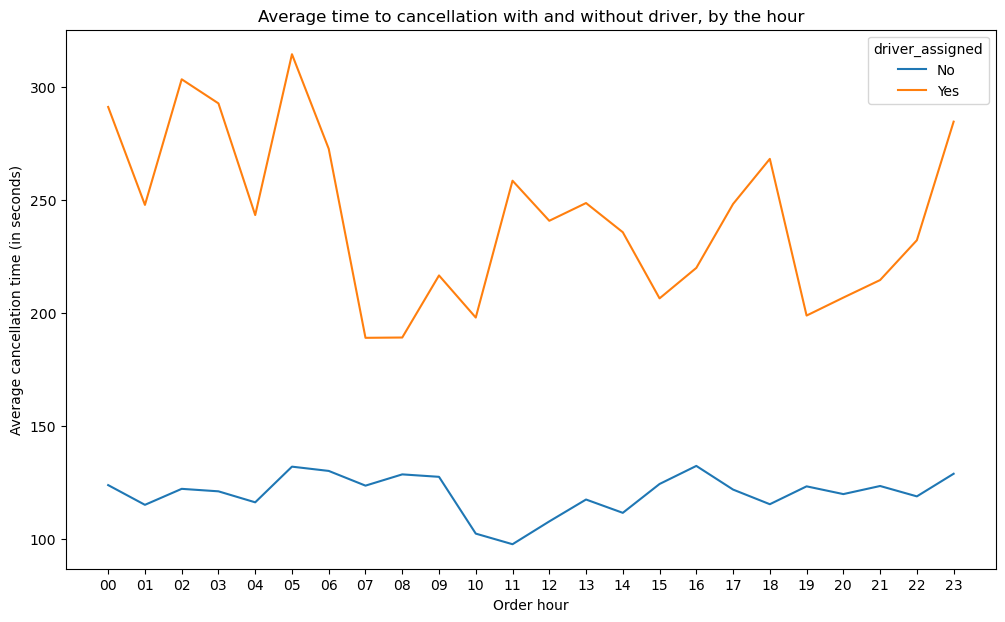

In [11]:
#Plotting the data
series_q3 = filled_mean_df_orders.groupby(['order_time','driver_assigned'])['cancellations_time_in_seconds'].mean()
series_q3.reset_index().pivot(index='order_time',
                              columns='driver_assigned',
                              values='cancellations_time_in_seconds').plot(figsize= (12,7),
                                                              legend=True, 
                                                              xticks=range(0,24),
                                                              title='Average time to cancellation with and without driver, by the hour',
                                                              ylabel='Average cancellation time (in seconds)',
                                                              xlabel='Order hour')
plt.show()

#### Plot the distribution of average ETA by hours. How can this plot be explained?

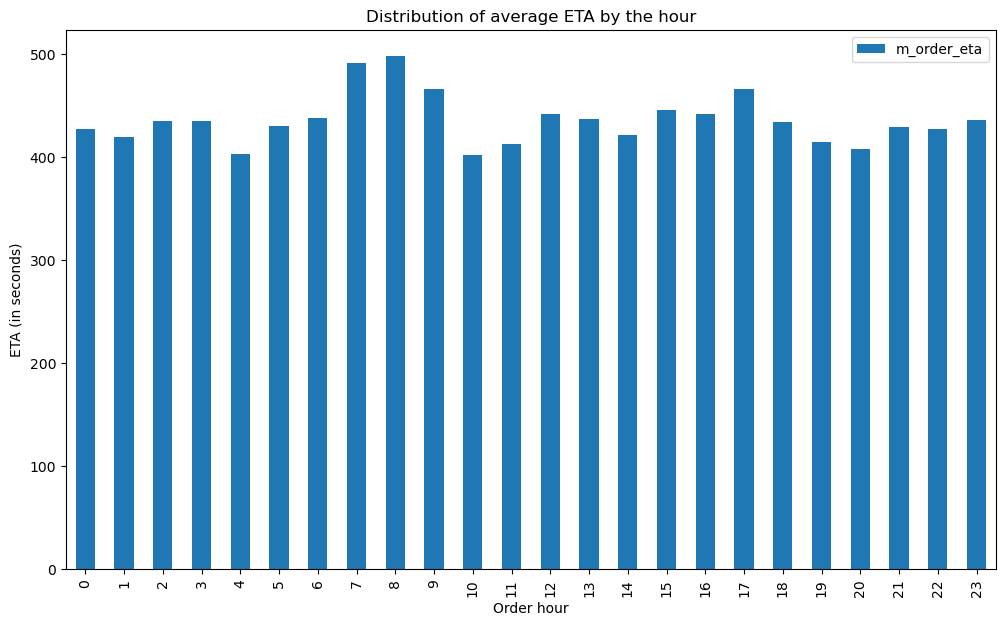

In [12]:
#sequence_q4 = df_orders.groupby('order_time')['m_order_eta'].mean()
df_orders_eta_mean = df_orders

df_orders_eta_mean['m_order_eta'] = df_orders_eta_mean['m_order_eta'].fillna(value=df_orders_eta_mean['m_order_eta'].mean())
df_orders_eta_mean.groupby('order_time')['m_order_eta'].mean().plot(kind='bar',
                                                                    figsize= (12,7),
                                                                    legend=True, 
                                                                    xticks=range(0,24),
                                                                    title='Distribution of average ETA by the hour',
                                                                    ylabel='ETA (in seconds)',
                                                                    xlabel='Order hour')
plt.show()

#### Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [53]:
#Map (lat, lon) → H3 hex at resolution 8
df_orders['hex_map'] = df_orders.apply(lambda x: h3.latlng_to_cell( x['origin_latitude'], x['origin_longitude'], 8), axis= 1)
#Count orders per hex
orders_per_hex = df_orders.groupby('hex_map')['order_gk'].count().sort_values(ascending=False).reset_index(name='order_count') #index is reset to get 2 columns instead of series
#Getting hexes that have 80% of the orders
#orders_per_hex is in descending order, so do cummulative sum of orders in each hex and divide by total number of orders
# all entries where cummulative sum/total number of orders <= 0.8 are in the top 80% zone
total_orders = df_orders['order_gk'].count()
orders_per_hex['cum_sum'] = orders_per_hex['order_count'].cumsum()
orders_per_hex['hex_zone'] = orders_per_hex['cum_sum']/total_orders
orders_per_hex_top_80 = orders_per_hex.query('hex_zone <= 0.8')
orders_per_hex_top_80

,hex_map,order_count,cum_sum,hex_zone
0,88195d2b1dfffff,1497,1497,0.139698
1,88195d2b1bfffff,870,2367,0.220885
2,88195d2b15fffff,774,3141,0.293113
3,88195d2b11fffff,707,3848,0.359089
4,88195d2b19fffff,667,4515,0.421333
5,88195d284dfffff,653,5168,0.482270
6,88195d2a27fffff,414,5582,0.520903
7,88195d2b0bfffff,372,5954,0.555618
8,88195d2a25fffff,362,6316,0.589399
9,88195d2b13fffff,346,6662,0.621687


In [54]:
#Visualise with Folium
#create base map centred on mean location of df_orders
base_map = folium.Map(location=[df_orders['origin_latitude'].mean(), df_orders['origin_longitude'].mean()],zoom_start=13)
# Create color scale for cancellations
color_map = cm.LinearColormap(colors=['green','yellow','red'],
                              vmin=orders_per_hex_top_80['order_count'].min(),
                              vmax=orders_per_hex_top_80['order_count'].max(),
                              caption='Number of Cancellations')
color_map.add_to(base_map)

#Add each hex to map
""" The error occurs because you're trying to access dictionary keys from a tuple. When using `iterrows()`, it returns a tuple 
where the first element is the index and the second element is the Series containing the row data.
The issue is in how you're accessing the row data in your loop. You're trying to access `row['hex_map']` and `row['order_count']` 
directly, but `row` is a tuple, not a dictionary. so you need to iterate with a dummy variable in the loop to map to key while row is mapped to value"""
for dummy, row in orders_per_hex_top_80.iterrows():
    hex_boundary = h3.cell_to_boundary(row['hex_map'])
    fill_color = color_map(row['order_count'])
    folium.Polygon(
        locations=hex_boundary,
        color="black",           # border color
        weight=0.5,              # border thickness
        fill=True,
        fill_opacity=0.6,
        fill_color=fill_color,
    ).add_to(base_map)

base_map